# Text Data

In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

df = pd.read_csv("sna_pull_request_metrics.csv")

In [133]:
#columns not being used in this model
columns = ['pr_number','created_at','merged_at','issue_comments_text','review_comments_text','reviews_text','issue_text', 'labels']

In [134]:
# if column is not in columns, drop it
for column in df.columns:
    if column not in columns:
        df.drop(column, axis=1, inplace=True)

In [135]:
# Function to remove specific prefixes from labels
def remove_prefixes(labels):
    if pd.isna(labels):
        return labels
    prefixes = ['type:', 'scope:', 'platform:', 'status:', 'other:','[',']']
    for prefix in prefixes:
        labels = labels.replace(prefix, '')
    return labels

# Apply the function to the 'Labels' column
df['labels'] = df['labels'].apply(remove_prefixes)



## Calculating hours and assigning groups

In [136]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['merged_at'] = pd.to_datetime(df['merged_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600


In [137]:
# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue_Lifetime(hours)'] < 6),  # less than 6 hours - group 1
    (df['Issue_Lifetime(hours)'] >= 6) & (df['Issue_Lifetime(hours)'] < 48), # between 6 hours and 2 days - group 2
    (df['Issue_Lifetime(hours)'] >= 48) & (df['Issue_Lifetime(hours)'] < 720),  # between 2 days and a month - group 3
    (df['Issue_Lifetime(hours)'] >= 720)  # more than a month - group 4
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4]
group_dict={
    1: 'Less than 6 hours',
    2: 'Between 6 hours and 2 days',
    3: 'Between 2 days and a month',
    4: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)

## Graphing the distribution

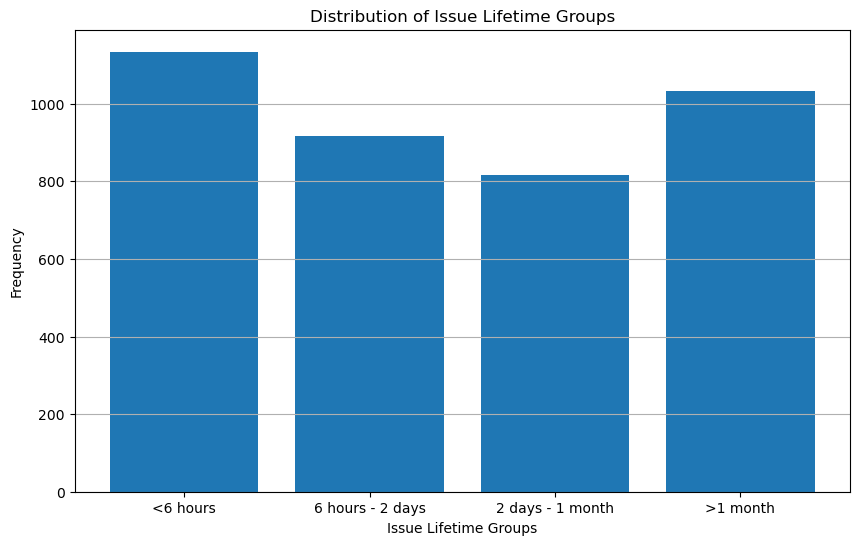

In [138]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<6 hours','6 hours - 2 days', '2 days - 1 month', '>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

In [139]:
# Drop the numerical columns
drop_columns = ['pr_number','created_at','merged_at','Issue_Lifetime(hours)']

df.drop(drop_columns, axis=1, inplace=True)

In [140]:
#pip install pandas emoji openai tiktoken sklearn

## Cleaning the data

In [141]:
# Importing libraries
import pandas as pd
import emoji
import re
import string
import json
import openai
import sklearn

In [142]:
# Initialize counters for text cleaning
cleaned_count = 0
original_count = 0

# Text cleaning function
def clean_text(text):
    global cleaned_count, original_count

    if not isinstance(text, str):
        original_count += 1
        return text

    # Remove double quotation marks
    text = text.replace('"', '')

    # Remove text starting with "DevTools" and ending with "(automated)"
    text = re.sub(r'DevTools.*?\(automated\)', '', text)

    # Lowercasing should be one of the first steps to ensure uniformity
    text = text.lower()

    # Remove emojis
    text = emoji.demojize(text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)

    # Remove '#' characters
    text = text.replace("#", "")

    # Remove consecutive whitespaces and replace with a single space
    text = re.sub(r'\s+', ' ', text)

    # Split the text into words
    words = text.split()

    # Remove words that are over 20 characters
    words = [word for word in words if len(word) <= 20]

    # Join the remaining words back into cleaned text
    cleaned_text = ' '.join(words)

    cleaned_count += 1
    return cleaned_text

df['labels'] = df['labels'].apply(clean_text)
df['issue_comments_text'] = df['issue_comments_text'].apply(clean_text)
df['review_comments_text'] = df['review_comments_text'].apply(clean_text)
df['reviews_text'] = df['reviews_text'].apply(clean_text)
df['issue_text'] = df['issue_text'].apply(clean_text)

In [143]:
# features is  dataframe without Issue Lifetime
features = df.drop('Issue Lifetime', axis=1)
target = df['Issue Lifetime']

## Split the data

In [144]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [145]:
# Open the file in write mode
with open('/Users/atu/Documents/TTS/text_issue_lifetime_data.jsonl', 'w', encoding='utf-8') as f:
    # Iterate over the rows in the DataFrame
    for index, row in df_train.iterrows():
        # Create the user message by formatting the prompt with the valuea frome each column for each row
        user_message = f"Classify, using ONLY 1 NUMBER between 1 and 4, the following GitHub issue, where 1 is 'Less than 6 hours', 2 is 'Between 6 hours and 2 days', 3 is 'Between 2 days and a month', and 4 is 'More than a month', based on its features: - Labels: {row['labels']}\n  - Issue Text: {row['issue_text']}\n - Issue Comments: {row['issue_comments_text']}\n - Review Comments: {row['review_comments_text']}\n - Reviews: {row['reviews_text']}\n"
        
        # Create the assistant message by taking the label
        assistant_message = str(row['Issue Lifetime'])
        
        # Construct the conversation object
        conversation_object = {
            "messages": [
                {"role": "system", "content": "GitHub Issue Lifetime Classifier"},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": assistant_message}
            ]
        }
        
        # Write the conversation object to one line in the file
        f.write(json.dumps(conversation_object, ensure_ascii=False) + '\n')

In [146]:
# Invoking the API
from openai import OpenAI
client = OpenAI(api_key = 'openai-api-key')


### Training from the file ##

In [147]:
## Uplopading a training file
'''ft_file = client.files.create(
  file=open("/Users/atu/Documents/TTS/text_issue_lifetime_data.jsonl", "rb"),
  purpose="fine-tune"
)
ft_file '''

'ft_file = client.files.create(\n  file=open("/Users/atu/Documents/TTS/text_issue_lifetime_data.jsonl", "rb"),\n  purpose="fine-tune"\n)\nft_file '

In [148]:
## Creating a fine-tuned model
'''ft_job = client.fine_tuning.jobs.create(
  training_file=ft_file.id, 
  model="gpt-3.5-turbo",
  suffix= "issueLifetime"
)
ft_job'''


'ft_job = client.fine_tuning.jobs.create(\n  training_file=ft_file.id, \n  model="gpt-3.5-turbo",\n  suffix= "issueLifetime"\n)\nft_job'

In [149]:
# Check the status of the fine-tuning job
fine_tuning_job_id = 'ftjob-AZjngftt8mfJ033qQzCFY53a'

job_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)

if job_status.status == 'succeeded':
    fine_tuned_model = job_status.fine_tuned_model
    print("Fine-tuned model ID:", fine_tuned_model)
elif job_status.status == 'failed':
    print("Fine-tuning job has failed.")
else:
    print("Fine-tuning job has not completed yet.") 

Fine-tuned model ID: ft:gpt-3.5-turbo-0125:northern-arizona-university-nau:issuelifetime:9e64OXKH


In [156]:
# Retrieving the state of a fine-tune
fine_tuning_job_id = 'ftjob-AZjngftt8mfJ033qQzCFY53a'

job_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)

tts_ft_model = client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model
print(tts_ft_model)

ft:gpt-3.5-turbo-0125:northern-arizona-university-nau:issuelifetime:9e64OXKH


In [157]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=fine_tuning_job_id, limit=20)


SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-EcEWyZUMPHGmSmoXdpBWHCDT', created_at=1719343486, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-sqh3RBFu6ajAyo34HX09eFNN', created_at=1719343481, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:northern-arizona-university-nau:issuelifetime:9e64OXKH', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-N8W9jQoy3bkifzWRSQaLJH5s', created_at=1719343481, level='info', message='Checkpoint created at step 1557 with Snapshot ID: ft:gpt-3.5-turbo-0125:northern-arizona-university-nau:issuelifetime:9e64OOKK:ckpt-step-1557', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-P86Xt4bcOYkgwAD9E6yGojGs', created_at=1719343481, level='info', message='Checkpoint created at step 1038 with Snapshot ID: ft:gpt-3.5-turbo-0125:norther

## Utilising Fine Tuned Model ##

In [158]:
import openai
import time
import pandas as pd
import concurrent.futures
import tiktoken
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report


openai.api_key ='openai-api-key'

In [159]:
# max_token here should be one since the class (1,2,3,4) is one token long. 
def query_chatgpt(prompt, model, temperature=0.0,  max_tokens=1, max_retries=5):
    """
    Function to query ChatGPT-4 with a given prompt, with retries for timeouts.

    :param prompt: Prompt string to send to ChatGPT-2.5
    :param model: The model to use, default is ChatGPT-3.5
    :param max_tokens: Maximum number of tokens to generate
    :param max_retries: Maximum number of retries for timeout
    :return: Response from ChatGPT-3.5 or None if all retries fail
    """
    attempt = 0
    max_content_tokens = 3999
    encoding = tiktoken.get_encoding("cl100k_base")
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Function to truncate the message and avoid passing the limit of 4k tokens per gpt-3.5 fine-tuned model limitations
    def truncate_message(message, max_length):
        tokens = encoding.encode(message)
        if len(tokens) > max_length:
            truncated_tokens = tokens[:max_length]
            message = encoding.decode(truncated_tokens)
        return message

    # Truncate the prompt if necessary
    prompt = truncate_message(prompt, max_content_tokens)

    while attempt < max_retries:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(
                openai.chat.completions.create,
                model=model,
                messages=[{"role": "system", "content": "GitHub Issue Lifetime Classifier"}, {"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature
            )
            try:
                response = future.result(timeout=5)  # 5 seconds timeout
                return response.choices[0].message.content
            except concurrent.futures.TimeoutError:
                print(f"Attempt {attempt + 1}/{max_retries} - Request timed out. Retrying...")
            except Exception as e:
                print(f"Attempt {attempt + 1}/{max_retries} - An error occurred: {e}")
            finally:
                attempt += 1

    print("Failed to get a response after several retries.")
    return None
    
labels =[ 1, 2, 3, 4]

In [160]:
y_true = []
y_pred = []

iterations = len(df_test)
lifetime = df_test['Issue Lifetime']
predictors = df_test.drop('Issue Lifetime', axis=1)

# Now let's loop through the test data and classify the GitHub issues
for i, row in df_test.iterrows():
    correct_label = int(row['Issue Lifetime'])  # Access the correct label directly from the row
    description = row.drop('Issue Lifetime').to_string()  # Get the row data as a string
    #description = f"{test_data_facebook.iloc[i]['title']} \n {test_data_facebook.iloc[i]['body']}"
    print(f"Correct PR type: {correct_label}")
    
    #prompt = f"Classify, IN ONLY 1 WORD, the following GitHub issue as 'feature', 'bug', or 'question' based on its title and body:\n{description}"
    prompt = f"Classify, using ONLY 1 NUMBER between 1 and 4, the following GitHub issue, where 1 is 'Less than 6 hours', 2 is 'Between 6 hours and 2 days', 3 is 'Between 2 days and a month', and 4 is 'More than a month', based on its features: - Labels: {row['labels']}\n  - Issue Text: {row['issue_text']}\n - Issue Comments: {row['issue_comments_text']}\n - Review Comments: {row['review_comments_text']}\n - Reviews: {row['reviews_text']}\n"

    response = query_chatgpt(prompt, tts_ft_model)
    
    if response is None:
        print("Failed to get a response after several retries. Skipping this item.")
        continue  # Skip this iteration and move to the next one
    
    # Clean the response to keep only letters (and optionally numbers)
    predicted_label = int(response)
    print(f"Predicted PR Lifetime: {predicted_label}")
    
    # Append to lists for evaluation
    y_true.append(correct_label)
    y_pred.append(predicted_label)
    time.sleep(3)  # Wait for 3 seconds before retrying

Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR Lifetime: 1
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 3
Predicted PR Lifetime: 3
Correct PR type: 1
Predicted PR Lifetime: 2
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 4
Predicted PR Lifetime: 4
Correct PR type: 1
Attempt 1/5 - Request timed out. Retrying...
Predicted PR Lifetime: 1
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 1
Predicted PR Lifetime: 2
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 1
Predicted PR

In [161]:
# Calculate weighted average F1-score, precision, and recall
f1 = f1_score(y_true, y_pred, labels=labels, average='weighted')
precision = precision_score(y_true, y_pred, labels=labels, average='weighted')
recall = recall_score(y_true, y_pred, labels=labels, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Calculate TP, FP, FN, TN
results = {}
for i, label in enumerate(labels):
    results[label] = {'TP': cm[i, i]}
    results[label]['FP'] = cm[:, i].sum() - cm[i, i]
    results[label]['FN'] = cm[i, :].sum() - cm[i, i]
    results[label]['TN'] = cm.sum() - (results[label]['TP'] + results[label]['FP'] + results[label]['FN'])

# Print results_fb
for label, metrics in results.items():
    print(f"{label}: {metrics}")

# Save results_fb to CSV
results_df = pd.DataFrame(results).T
results_df['F1-score'] = f1
results_df['Recall'] = recall
results_df['Precision'] = precision

results_df.to_csv('confusion_matrix.csv')

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1-score = {f1}")

1: {'TP': 148, 'FP': 70, 'FN': 73, 'TN': 489}
2: {'TP': 76, 'FP': 82, 'FN': 113, 'TN': 509}
3: {'TP': 102, 'FP': 91, 'FN': 59, 'TN': 528}
4: {'TP': 179, 'FP': 32, 'FN': 30, 'TN': 539}
Precision = 0.6453070385767553
Recall = 0.6474358974358975
F1-score = 0.644523455059537


In [163]:
#accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy = {accuracy}")

Accuracy = 0.6474358974358975
